In [1]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import colorlover as cl


import neuro_morpho_toolbox as nmt
%matplotlib inline

/home/penglab/anaconda3/lib/python3.7/site-packages/neuro_morpho_toolbox-0.1-py3.7.egg/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.82
Loading CCF brain structure data...
Loading time: 0.00
Loading selected CCF Atlas and Contour data...
Loading time: 0.93


**seu_ns: SEU-Allen's data**

**all_ns: SEU + Janelia's data**

Input .swc data file, total **1602**.

In [2]:
import pickle
pickle_in = open("/home/penglab/FeaCal/all_ns.pickle","rb")
[ns] = pickle.load(pickle_in)


In [3]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

ns = nmt.neuron_set('/home/penglab/FeaCal/allData')
pickle.dump([ns], open("/home/penglab/FeaCal/all_ns.pickle", "wb"))

# 2.1) Distribution of soma location
* Set the *thre* value to determine the threshold for showing the region distribution
* mouseDF is a dataframe recording the ['Child ID', 'Child num', 'ABBR', 'FatherRe'] of 1327 brain regions
* Not going to write mouseDF to the pkg, just to show the result

## 2.1.1) Based on 7 regions
* including Isocortex, OLF, HPF, CTXsp, CNU, BS, CB; 


In [4]:

mouseDF = pd.read_excel('/home/penglab/FeaCal/dataSource/mouseDF.xlsx',index=0)
abbrlist = []
for i in mouseDF.loc[:,'idx']:
    if i in nmt.bs.level.index:
        abbr = nmt.bs.level.loc[i,'Abbreviation']
        abbrlist.append(abbr)
    else:
        print(i)
        abbrlist.append('unknown')
mouseDF.loc[:,'ABBR']=abbrlist
del mouseDF[1]
mouseDF.set_index(['idx'],inplace=True)

somaRegDF = ns.features['soma_features'].region.copy()
large_list = [ 'BS', 'CB','CNU', 'CTXsp', 'HPF','Isocortex', 'OLF']
mouseDF['FatherRe'] = mouseDF.loc[:,'ABBR']
        
for B_iter in large_list :
    temp=[]
    if nmt.bs.name_to_id(B_iter) in mouseDF.index:
        for child_iter in mouseDF.loc[nmt.bs.name_to_id(B_iter),'Child ID'].split():
            if int(child_iter) in mouseDF.index:
                mouseDF.loc[int(child_iter),'FatherRe'] = B_iter
            else:
                print(child_iter)
            #temp.append(nmt.bs.level.loc[int(child_iter),'Abbrevation'])
somaRegDF['main7Region'] = somaRegDF['Region']     
for iterR in somaRegDF.index:
    if somaRegDF.loc[iterR,'Region'] in mouseDF['ABBR'].tolist():
        somaRegDF.loc[iterR,'main7Region'] = mouseDF[mouseDF['ABBR']==somaRegDF.loc[iterR,'Region']].iloc[0,-1]

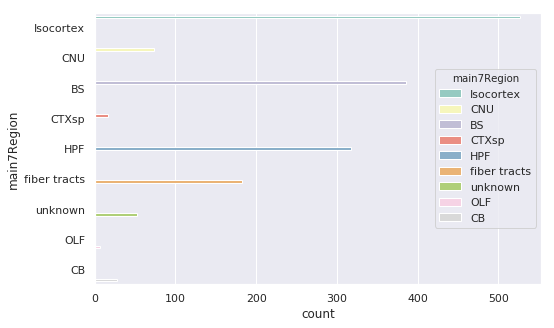

In [5]:
ct = somaRegDF["main7Region"].value_counts().sort_values(ascending=False)
thre = 0
sns.set(rc={'figure.figsize':(8,5)})
_ = sns.countplot(y="main7Region", 
                  data=somaRegDF.loc[somaRegDF.main7Region.isin(ct.index[ct>thre])],
                  hue = "main7Region", palette="Set3"
                 )


## 2.1.2) Projecting to three directions: "Horizontal","Coronal","Sagittal"

**2.1.2.1) By setting color="majorSOMA" in cell_in_map, the soma point will be shown with 7 major regions**
* Here set the 'Cluster' column in ns.metadata to be the region name.

**2.1.2.2) By setting color="soma" in cell_in_map, the soma point will be shown with 256 colors**
* No need to set the 'Cluster' column in ns.metadata to be the region name.

<blockquote>Example: Plot three views in a single plot with 256 color</blockquote>

```Python
    from neuro_morpho_toolbox.plot import cell_in_map
    fig, ax = plt.subplots(3,1, figsize=(7.5, 10))
    cur_list = ns.metadata.index.tolist()
    cell_in_map(ns.neurons, cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="soma",alpha=1,ax=ax[0])
    cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation, 
                view="Coronal", color="soma", alpha=1,ax=ax[1])
    cell_in_map(ns.neurons,cur_list, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Sagittal", color="soma", alpha=1, ax=ax[2])
    #fig.savefig('../Figure/Cell_in_map.pdf')
```

**2.1.2.1)  Plot singel view('Horizontal') with only 7 major regions**

Illustrating soma locations inside a brain from horizontal view:


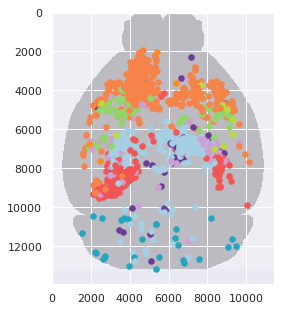

In [6]:
from neuro_morpho_toolbox.plot import cell_in_map
fig, ax =  plt.subplots(1,1)
cur_list = ns.metadata.index.tolist()
somaRegDF['Cluster']= somaRegDF.loc[:,'main7Region']
somaRegDF
cell_in_map(ns.neurons, cur_list, somaRegDF,ccf_annotation=nmt.annotation,view="Horizontal",color="majorsoma",ax=ax
           )
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

**2.1.2.2) Plot singel view('Horizontal') with all regions**

Illustrating soma locations inside a brain from horizontal view:


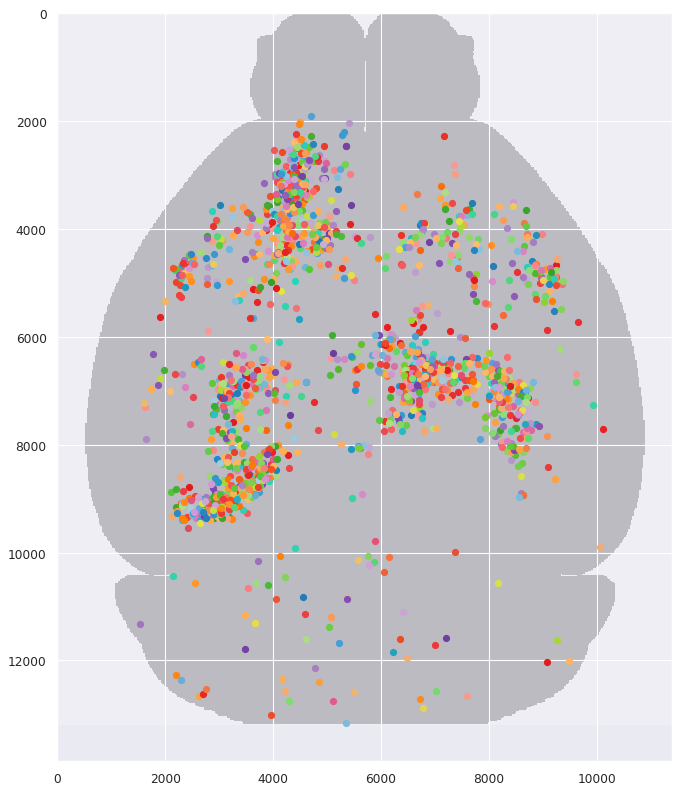

In [7]:
from neuro_morpho_toolbox.plot import cell_in_map
cur_list = ns.metadata.index.tolist()
somaRegDF
cell_in_map(ns.neurons, cur_list, ns.metadata,ccf_annotation=nmt.annotation,view="Horizontal", color="soma")
#fig.savefig('/home/penglab/FeaCal/horizonsaved')

## 2.1.3) Use wordcloud to illustrate the information
* Not going to write into the pkg just to show the result

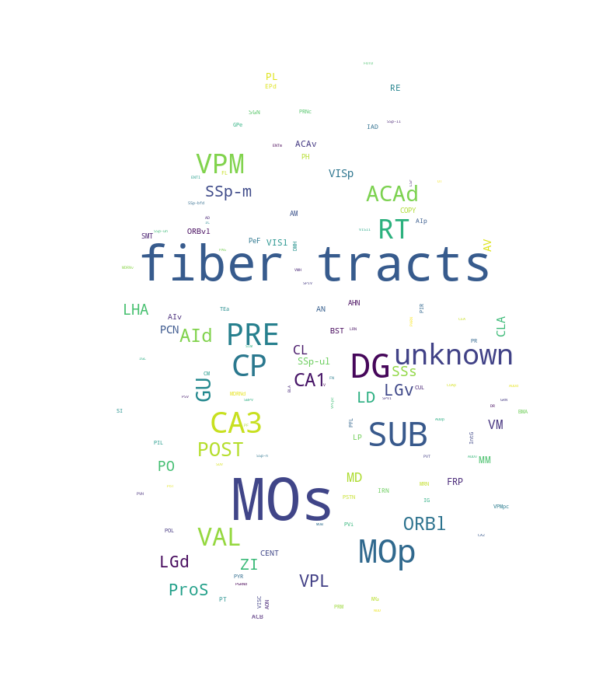

In [8]:
import jieba               
from wordcloud import WordCloud   
from PIL import Image
img = np.array(Image.open("/home/penglab/Desktop/mask.png"))
region_all, count = np.unique(somaRegDF['Region'], return_counts=True)
somaDIC = {}
for i in range(len(region_all)):
    #if region_all[i] == 'fiber tracts':
        #continue
    somaDIC[region_all[i]] = count[i]

wc = WordCloud(background_color='white',width=240,height=160,max_font_size=75,min_font_size=5,
               colormap="viridis", mask = img)
wc.generate_from_frequencies(somaDIC)
#save the file
wc.to_file('/home/penglab/Desktop/WC.png') 
# Show the plot
plt.figure(figsize=(10,20)) 
plt.imshow(wc,interpolation='bilinear')
plt.axis("off")
plt.show()


## 1.1) Analyze soma location to obtain confident list

**Read the downsample-25 array with selected CCF region**

<blockquote>Example
    
```Python
nmt.ccfArray
```
</blockquote>

**Read the 6-nearest neighbor Contour Matrix with CCF index on**

* Originally, selected CCF has *316* regions, after using all the selected index to replace the child region, there are *337* regions.
* Therefore, there are 23 regions that show up in the nrrd array but have not been mentioned in the above selected CCF or its child region

<blockquote>Example
    
```Python
nmt.Contour01
```
</blockquote>

***Use nmt.disCal to obtain a DataFrame with columns ['x', 'y', 'z', 'SqEuclidean', 'min_Euclidean']***

<blockquote>Example
</blockquote>

```Python
    somaDis = nmt.disCal(ns.features['soma_features'].raw_data,
                         CCF_6_01,ccfArray, 10, flipF = True)
```


In [9]:
pickle_in = open("/home/penglab/NMTcode/somaDis.pickle","rb")
example_ = pickle.load(pickle_in)
somaDis = example_[0]

SelectedDF is obtained by throwing the unknown region and fiber tracts soma away

In [10]:
selectedDF = somaDis[somaDis['SqEuclidean'] != 'unknown'].copy()
selectedDF = selectedDF[selectedDF['Region'] != 'fiber tracts'].copy()
confi_list = selectedDF.index.tolist()
print('Number of confident neurons are '+ str(len(confi_list)))
se_list = selectedDF.index.tolist()

Number of confident neurons are 1006


## Calculate ARI according to a given list

### Generate the dataframe using pickCLUSTERpara(method)

<blockquote>Example</blockquote>

```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy',se_list)
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans',se_list)
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan',se_list)
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan',se_list)
    snn_resultDF = ns.pickCLUSTERpara('snn',se_list)
```
or if want to calculate ARI for all neurons, just use
```Python
    hier_resultDF = ns.pickCLUSTERpara('hierarchy')
    kmeans_resultDF = ns.pickCLUSTERpara('kmeans')
    dbscan_resultDF = ns.pickCLUSTERpara('dbscan')
    hdbscan_resultDF = ns.pickCLUSTERpara('hdbscan')
    snn_resultDF = ns.pickCLUSTERpara('snn')
```

### Print out the most proper parameter by maximizing ARI

<blockquote>Example</blockquote>

```Python
    hierbest = findBESTpara(hier_resultDF,[15,45],16)
    kmeansbest = findBESTpara(kmeans_resultDF,[15,45],16)
    dbscanbest = findBESTpara(dbscan_resultDF,[15,45],16)
    hdbscanbest = findBESTpara(hdbscan_resultDF,[15,45],16)
    snnbest = findBESTpara(snn_resultDF,[15,45],16)
```

## Using co-clustering towards the selected parameters

### Feature 1: projection patterns

In [11]:
_ = ns.ReduceDimUMAP(feature_set="projection_features", n_neighbors=100)

In [12]:
AP_hierDF = pd.read_excel('/home/penglab/NMTcode/AP_hier_co_cluster.xlsx', index_col=0)
AP_kmeansDF = pd.read_excel('/home/penglab/NMTcode/AP_kmeans_co_cluster.xlsx', index_col=0)
AP_dbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_dbscan_co_cluster.xlsx', index_col=0)
AP_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/AP_hdbscan_co_cluster.xlsx', index_col=0)
AP_snnDF = pd.read_excel('/home/penglab/NMTcode/AP_snn_co_cluster.xlsx', index_col=0)

**Hierarchy**
* 0.19707750078003858
* 0.19008590059586536   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


**Kmeans**
* 0.22447282585026812
* 0.23757234135967928   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


**DBSCAN**
* 0.09026416477575772
* 0.09236174131638324   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
    
```


**HDBSCAN**
* 0.0472103345317394
* 0.08773477141372713   Not specified

<blockquote>Example</blockquote>

```Python
  _ = ns.bestCoCluster(AP_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)

```


**SNN**
* 0.20760902962055355
* 0.2203302483933457   Not specified

<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(AP_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```


### Feature 2: Soma Location

In [13]:
SL_hierDF = pd.read_excel('/home/penglab/NMTcode/SL_hier_co_cluster.xlsx', index_col=0)
SL_kmeansDF = pd.read_excel('/home/penglab/NMTcode/SL_kmeans_co_cluster.xlsx', index_col=0)
SL_dbscanDF = pd.read_excel('/home/penglab/NMTcode/SL_dbscan_co_cluster.xlsx', index_col=0)
SL_hdbscanDF = pd.read_excel('/home/penglab/NMTcode/SL_hdbscan_co_cluster.xlsx', index_col=0)
SL_snnDF = pd.read_excel('/home/penglab/NMTcode/SL_snn_co_cluster.xlsx', index_col=0)

**Hierarchy**
* 0.12411518354928672
* 0.13524559251557391   Not specified

<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(SL_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)

```





**Kmeans**
* 0.1908960974370685
* 0.18858694643298865   Not specified


<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(SL_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```





**DBSCAN**
* 0.1519487699593167
* 0.11290188493510778   Not specified


<blockquote>Example</blockquote>

```Python
_ = ns.bestCoCluster(SL_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
```






**HDBSCAN**
* 0.09636071813601153
* 0.08173723592554322   Not specified


<blockquote>Example</blockquote>

```Python
 = ns.bestCoCluster(SL_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
    
```






_

**SNN**
* 0.17827195932588275
* 0.20654237679778586   Not specified


<blockquote>Example</blockquote>

```Python
 = ns.bestCoCluster(SL_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)
    
```

## Illustrating clustering result

In [14]:
hier_SL_list_se = []
hier_SL_list = []

kmeans_SL_list_se = []
kmeans_SL_list = []

dbscan_SL_list_se = []
dbscan_SL_list = []

hdbscan_SL_list_se = []
hdbscan_SL_list = []

snn_SL_list_se = []
snn_SL_list = []

In [15]:
hier_AP_list_se = []
hier_AP_list = []

kmeans_AP_list_se = []
kmeans_AP_list = []

dbscan_AP_list_se = []
dbscan_AP_list = []

hdbscan_AP_list_se = []
hdbscan_AP_list = []

snn_AP_list_se = []
snn_AP_list = []

In [16]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(SL_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(SL_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    hier_SL_list_se.append(tempARI_se)
    hier_SL_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.0783017442355305
0.07825339709565349
Loading process: 0.03
0.0783017442355305
0.09225809575498482
Loading process: 0.07
0.09830527365706426
0.10807867735036347
Loading process: 0.10
0.11223341826775049
0.12088066738256906
Loading process: 0.13
0.12774426279245732
0.13621358389222726
Loading process: 0.17
0.12411518354928672
0.13524559251557391
Loading process: 0.20
0.15052625138608247
0.14980334961882769
Loading process: 0.23
0.18003882087702672
0.17713035457475262
Loading process: 0.27
0.20864806414420917
0.20456520683424045
Loading process: 0.30
0.20526116590480065
0.20633335771161587
Loading process: 0.33
0.20526116590480065
0.17988082591861299
Loading process: 0.37
0.2203669222200479
0.18827222943151703
Loading process: 0.40
0.21798675336902265
0.18568199904925523
Loading process: 0.43
0.2270949057444664
0.18952451577368268
Loading process: 0.47
0.22839819920588944
0.1901354118305745
Loading process: 0.50
0.2329484683686647
0.19190530319526666
Loading process: 0.53
0.234891713712

In [17]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(AP_hierDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    hier_AP_list_se.append(tempARI_se)
    hier_AP_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.11121685988838352
0.10647120380902618
Loading process: 0.03
0.1495128165258159
0.14325851449282392
Loading process: 0.07
0.15025926258799993
0.14609179364936248
Loading process: 0.10
0.1478294231751744
0.14537613909644267
Loading process: 0.13
0.17397809731672464
0.16854993664405094
Loading process: 0.17
0.19707750078003858
0.19008590059586536
Loading process: 0.20
0.20564625069554138
0.1978874411850649
Loading process: 0.23
0.20965531894800357
0.20040351691570135
Loading process: 0.27
0.20948374163374345
0.16713784219277755
Loading process: 0.30
0.22687042932450688
0.179040532672484
Loading process: 0.33
0.22864312268735532
0.18062450810469802
Loading process: 0.37
0.23643306729391383
0.18613139208469556
Loading process: 0.40
0.23963061073796224
0.18774600237271355
Loading process: 0.43
0.24334369506465578
0.1916490732623367
Loading process: 0.47
0.24556858555340366
0.192504536350535
Loading process: 0.50
0.23986495916219558
0.1901092573572703
Loading process: 0.53
0.239521076613782

In [18]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(SL_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(SL_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    kmeans_SL_list_se.append(tempARI_se)
    kmeans_SL_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.08912116522183636
0.10400625530513918
Loading process: 0.03
0.1335836481554925
0.14502627878266347
Loading process: 0.07
0.13171816660563276
0.14479358775958467
Loading process: 0.10
0.14379872073713623
0.15630518525140874
Loading process: 0.13
0.19111812869036285
0.18754189041622474
Loading process: 0.17
0.1908960974370685
0.18858694643298865
Loading process: 0.20
0.19530754437518125
0.19249291507837815
Loading process: 0.23
0.1988714846809931
0.1958711029423147
Loading process: 0.27
0.20506377245040605
0.2016672901715203
Loading process: 0.30
0.21493325253362008
0.20973833379264678
Loading process: 0.33
0.213531314619264
0.21052187355783217
Loading process: 0.37
0.21563250396280148
0.21170469925464627
Loading process: 0.40
0.21563250396280148
0.2045150326166258
Loading process: 0.43
0.21289505687932078
0.2039994887784528
Loading process: 0.47
0.21688027053285594
0.20669353022295092
Loading process: 0.50
0.21688027053285594
0.19851387590630679
Loading process: 0.53
0.220837095259062

In [19]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(AP_kmeansDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    kmeans_AP_list_se.append(tempARI_se)
    kmeans_AP_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.20328012940253945
0.21603915046785188
Loading process: 0.03
0.21047946055844519
0.2245035599606164
Loading process: 0.07
0.21151989903315585
0.21740801492175074
Loading process: 0.10
0.21936372412148292
0.22619145170898622
Loading process: 0.13
0.2100824150962344
0.2226320610092054
Loading process: 0.17
0.22447282585026812
0.23757234135967928
Loading process: 0.20
0.22354079757789763
0.19542914624671157
Loading process: 0.23
0.23318304892225372
0.19978816454864107
Loading process: 0.27
0.23602251974817792
0.203199136655368
Loading process: 0.30
0.23587205738564293
0.18209649890288154
Loading process: 0.33
0.2347297651570599
0.18136033845620414
Loading process: 0.37
0.24010705839100654
0.18513121058462287
Loading process: 0.40
0.24334217994182009
0.18637405718103106
Loading process: 0.43
0.24189899817939528
0.18455246411698822
Loading process: 0.47
0.24211980779310222
0.184641468989301
Loading process: 0.50
0.24211980779310222
0.1847970688441318
Loading process: 0.53
0.241574654037934

In [20]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(SL_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(SL_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    dbscan_SL_list_se.append(tempARI_se)
    dbscan_SL_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.11283585767453616
0.07209621415573016
Loading process: 0.03
0.11283585767453616
0.07477209066235854
Loading process: 0.07
0.11283585767453616
0.08237791474461366
Loading process: 0.10
0.1254754605521102
0.09357788855403454
Loading process: 0.13
0.13640700852196258
0.10290147715123422
Loading process: 0.17
0.1519487699593167
0.11290188493510778
Loading process: 0.20
0.1678308912603425
0.1220839775266248
Loading process: 0.23
0.1849703653580645
0.13182773035068965
Loading process: 0.27
0.19796040051272604
0.14016252839249752
Loading process: 0.30
0.20749637991438266
0.14655197548479787
Loading process: 0.33
0.2080782974432741
0.15261874617135712
Loading process: 0.37
0.216488687665678
0.15768160937091127
Loading process: 0.40
0.22158995053063507
0.16131330980334074
Loading process: 0.43
0.2241252776771966
0.163964193799233
Loading process: 0.47
0.2275362777805459
0.16724108249312206
Loading process: 0.50
0.22943288691650454
0.169416029534747
Loading process: 0.53
0.22943288691650454
0.

In [21]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(AP_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(AP_dbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    dbscan_AP_list_se.append(tempARI_se)
    dbscan_AP_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.060542646899464175
0.05669590892001431
Loading process: 0.03
0.06975753347342997
0.0668889660540484
Loading process: 0.07
0.07655342214237153
0.07453787841667583
Loading process: 0.10
0.08402092882553402
0.08039224993867826
Loading process: 0.13
0.0842926882625729
0.08584757707155223
Loading process: 0.17
0.09026416477575772
0.09236174131638324
Loading process: 0.20
0.09533339048384663
0.09898716263296305
Loading process: 0.23
0.09632069391423062
0.10310227160461022
Loading process: 0.27
0.10111043082379748
0.11137588603686846
Loading process: 0.30
0.11271124154478218
0.12021209986951856
Loading process: 0.33
0.12391715091030844
0.12898351637951078
Loading process: 0.37
0.13555550153567686
0.13719880587069289
Loading process: 0.40
0.14322772571904757
0.14329695244106685
Loading process: 0.43
0.15214676907139438
0.1494247979857229
Loading process: 0.47
0.15715545427807834
0.15654049331002137
Loading process: 0.50
0.16275544981279036
0.16262169806193957
Loading process: 0.53
0.17001293

In [22]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(SL_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(SL_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    hdbscan_SL_list_se.append(tempARI_se)
    hdbscan_SL_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.08252101621501418
0.06672341385961424
Loading process: 0.03
0.08171658130781062
0.06664903879713752
Loading process: 0.07
0.08439085016830523
0.06890541656607836
Loading process: 0.10
0.0844194995056323
0.06930202907299174
Loading process: 0.13
0.09642433096965854
0.08164852585854941
Loading process: 0.17
0.09636071813601153
0.08173723592554322
Loading process: 0.20
0.10874222127553085
0.09042238535641074
Loading process: 0.23
0.10874222127553085
0.09047366892587559
Loading process: 0.27
0.10710206548851385
0.0919898691026891
Loading process: 0.30
0.10710206548851385
0.09181308243366745
Loading process: 0.33
0.11775625037299015
0.10096862491915577
Loading process: 0.37
0.11775625037299015
0.10003925075311194
Loading process: 0.40
0.11775625037299015
0.09989803433533392
Loading process: 0.43
0.12275976720031671
0.10312565996349368
Loading process: 0.47
0.12275976720031671
0.10311830544501975
Loading process: 0.50
0.1238938321520059
0.1048886166337113
Loading process: 0.53
0.1291979774

In [23]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(AP_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(AP_hdbscanDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    hdbscan_AP_list_se.append(tempARI_se)
    hdbscan_AP_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.04181771188189714
0.06639810415558844
Loading process: 0.03
0.04192279411260678
0.07262616919142025
Loading process: 0.07
0.04194671865566084
0.07265377231498146
Loading process: 0.10
0.041955530584833575
0.07749664241316069
Loading process: 0.13
0.04259547233901482
0.08189619644751257
Loading process: 0.17
0.0472103345317394
0.08773477141372713
Loading process: 0.20
0.05108360896765353
0.09484895019006555
Loading process: 0.23
0.058587480398958655
0.10267259904550007
Loading process: 0.27
0.05781966562710657
0.10254218032979873
Loading process: 0.30
0.05781966562710657
0.10254412485742227
Loading process: 0.33
0.06177825331762412
0.10821742535996522
Loading process: 0.37
0.06279014911615168
0.11089081060786628
Loading process: 0.40
0.06509818387484256
0.11463227012254631
Loading process: 0.43
0.07041773400047763
0.12024251025873656
Loading process: 0.47
0.07349882015804891
0.1242269626670892
Loading process: 0.50
0.07622039783499053
0.12802166015860025
Loading process: 0.53
0.076220

In [24]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(SL_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(SL_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    snn_SL_list_se.append(tempARI_se)
    snn_SL_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.14719643936002277
0.17989692818734898
Loading process: 0.03
0.1479622903415672
0.18190065180744108
Loading process: 0.07
0.15975550741189024
0.1910470550968344
Loading process: 0.10
0.17104819187402723
0.19789082580190065
Loading process: 0.13
0.17116681830327524
0.2004926186597849
Loading process: 0.17
0.17827195932588275
0.20654237679778586
Loading process: 0.20
0.18287688158991766
0.2102364720739705
Loading process: 0.23
0.1864738564218732
0.21392612296173516
Loading process: 0.27
0.1899761414471845
0.21520674539716625
Loading process: 0.30
0.19208866737717745
0.2186038445857001
Loading process: 0.33
0.19208866737717745
0.2186038445857001
Loading process: 0.37
0.19234072173921
0.2202514057789749
Loading process: 0.40
0.19234072173921
0.2202514057789749
Loading process: 0.43
0.19236700560162384
0.22080793889633904
Loading process: 0.47
0.19302583764243364
0.2215061037432323
Loading process: 0.50
0.19304697552595784
0.2215317560747944
Loading process: 0.53
0.20394828108046797
0.2269

In [25]:
i = 0
for t_iter in range(15,45):
    i = i+1
    tempARI_se = ns.bestCoCluster(AP_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter, selected_list= se_list)
    tempARI = ns.bestCoCluster(AP_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = t_iter)
    
    snn_AP_list_se.append(tempARI_se)
    snn_AP_list.append(tempARI)
    print("Loading process: %.2f" % (i/30))


0.19174717252990292
0.19910214007565405
Loading process: 0.03
0.18351316408397578
0.19877706590101238
Loading process: 0.07
0.18557344639923049
0.20202927473550714
Loading process: 0.10
0.21087923047537638
0.21980625192287356
Loading process: 0.13
0.21449504110154108
0.22193831840780393
Loading process: 0.17
0.20760902962055355
0.2203302483933457
Loading process: 0.20
0.20780784523946322
0.22269107964179682
Loading process: 0.23
0.20649928916978716
0.22212420527044863
Loading process: 0.27
0.20970298294490627
0.2265249576045566
Loading process: 0.30
0.2145652271813402
0.23066438254889263
Loading process: 0.33
0.21662548638818663
0.2313224133440764
Loading process: 0.37
0.21714311734055314
0.23191823947749443
Loading process: 0.40
0.2206922337888593
0.2338851408204123
Loading process: 0.43
0.22646330910878984
0.2394445094087572
Loading process: 0.47
0.22646330910878984
0.23972251407004977
Loading process: 0.50
0.22954474611813766
0.2427338942377998
Loading process: 0.53
0.22954474611813

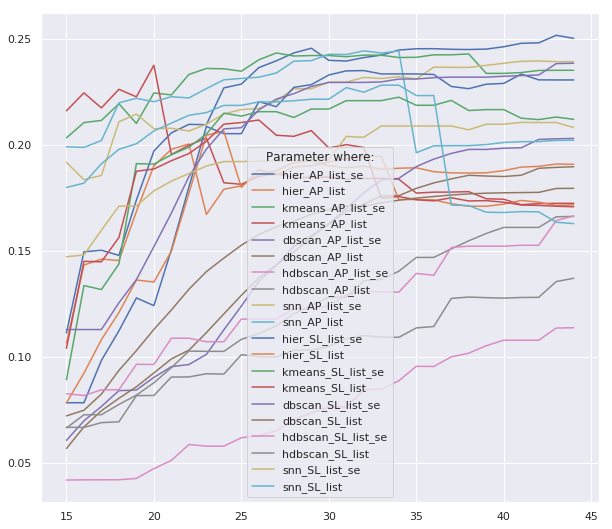

In [32]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,9))
x_ = range(15,45)
plt.plot(x_,hier_AP_list_se, label='hier_AP_list_se')
plt.plot(x_,hier_AP_list, label='hier_AP_list')
plt.plot(x_,kmeans_AP_list_se, label='kmeans_AP_list_se')
plt.plot(x_,kmeans_AP_list, label='kmeans_AP_list')
plt.plot(x_,dbscan_AP_list_se, label='dbscan_AP_list_se')
plt.plot(x_,dbscan_AP_list, label='dbscan_AP_list')
plt.plot(x_,hdbscan_AP_list_se, label='hdbscan_AP_list_se')
plt.plot(x_,hdbscan_AP_list, label='hdbscan_AP_list')
plt.plot(x_,snn_AP_list_se, label='snn_AP_list_se')
plt.plot(x_,snn_AP_list, label='snn_AP_list')
plt.plot(x_,hier_SL_list_se, label='hier_SL_list_se')
plt.plot(x_,hier_SL_list, label='hier_SL_list')
plt.plot(x_,kmeans_SL_list_se, label='kmeans_SL_list_se')
plt.plot(x_,kmeans_SL_list, label='kmeans_SL_list')
plt.plot(x_,dbscan_SL_list_se, label='dbscan_SL_list_se')
plt.plot(x_,dbscan_SL_list, label='dbscan_SL_list')
plt.plot(x_,hdbscan_SL_list_se, label='hdbscan_SL_list_se')
plt.plot(x_,hdbscan_SL_list, label='hdbscan_SL_list')
plt.plot(x_,snn_SL_list_se, label='snn_SL_list_se')
plt.plot(x_,snn_SL_list, label='snn_SL_list')
plt.legend(title='Parameter where:')
plt.show()

### Create a dataframe to store the result
前三百个是AP，0-30 是Hierarchy selected

In [90]:
import itertools

ARI_DF = pd.DataFrame(columns = ['FeatureSet','numCluster','RegionUsed','Method','ARI'],index = range(600))
ARI_DF.loc[0:300,'FeatureSet'] = 'AP'
ARI_DF.loc[300:,'FeatureSet'] = 'SL'
L = list(itertools.repeat("selected", 30))
for i in (list(itertools.repeat("Entire", 30))):
    L.append(i)
ARI_DF.loc[:,'RegionUsed']= L*10
ARI_DF.loc[:,'numCluster']= np.tile(range(15,45), 20)
ARI_DF.loc[:,'Method']= [ele for ele in ['Hierarchy','Kmeans','DBSCAN','HDBSCAN','SNN'] for _ in range(60)]*2
ARI_DF.iloc[0:30,4] = hier_AP_list_se
ARI_DF.iloc[30:60,4] = hier_AP_list
ARI_DF.iloc[60:90,4] = kmeans_AP_list_se
ARI_DF.iloc[90:120,4] = kmeans_AP_list
ARI_DF.iloc[120:150,4] = dbscan_AP_list_se
ARI_DF.iloc[150:180,4] = dbscan_AP_list
ARI_DF.iloc[180:210,4] = hdbscan_AP_list_se
ARI_DF.iloc[210:240,4] = hdbscan_AP_list
ARI_DF.iloc[240:270,4] = snn_AP_list_se
ARI_DF.iloc[270:300,4] = snn_AP_list
ARI_DF.iloc[300:330,4] = hier_SL_list_se
ARI_DF.iloc[330:360,4] = hier_SL_list
ARI_DF.iloc[360:390,4] = kmeans_SL_list_se
ARI_DF.iloc[390:420,4] = kmeans_SL_list
ARI_DF.iloc[420:450,4] = dbscan_SL_list_se
ARI_DF.iloc[450:480,4] = dbscan_SL_list
ARI_DF.iloc[480:510,4] = hdbscan_SL_list_se
ARI_DF.iloc[510:540,4] = hdbscan_SL_list
ARI_DF.iloc[540:570,4] = hdbscan_SL_list_se
ARI_DF.iloc[570:600,4] = hdbscan_SL_list
ARI_DF[['numCluster', 'ARI']] = ARI_DF[['numCluster', 'ARI']].astype(float)

In [ ]:
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

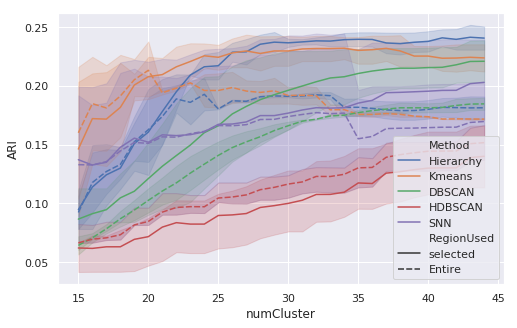

In [96]:
sns.lineplot(x="numCluster", y="ARI",style="RegionUsed", 
             hue="Method",        data=ARI_DF)

### Entire

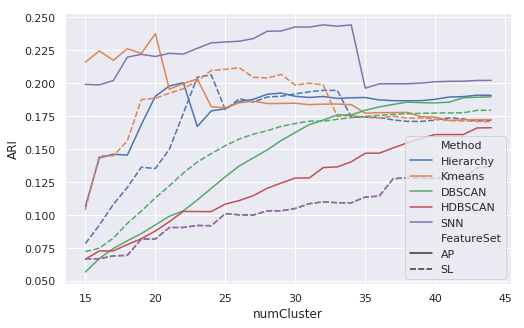

In [99]:
sns.lineplot(x="numCluster", y="ARI",style="FeatureSet", 
             hue="Method",        data=ARI_DF[ARI_DF['RegionUsed']=='Entire'])

### Selected

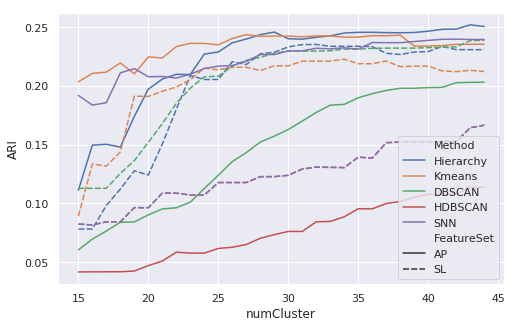

In [100]:
sns.lineplot(x="numCluster", y="ARI",style="FeatureSet", 
             hue="Method",        data=ARI_DF[ARI_DF['RegionUsed']=='selected'])

### Axon Projection Feature

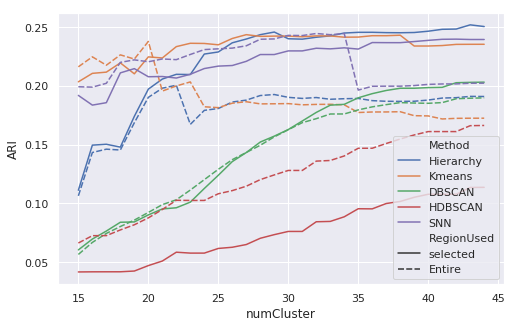

In [106]:
sns.lineplot(x="numCluster", y="ARI",style="RegionUsed", hue="Method", data=ARI_DF[ARI_DF['FeatureSet']=='AP'])

### Soma Location Feature

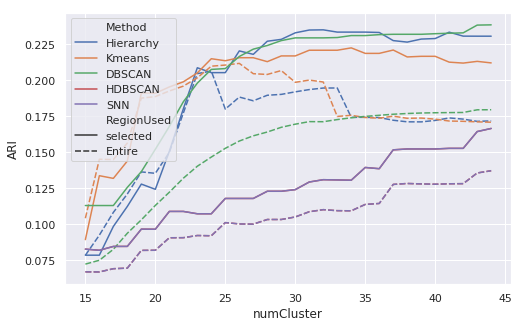

In [107]:
sns.lineplot(x="numCluster", y="ARI",style="RegionUsed", hue="Method", data=ARI_DF[ARI_DF['FeatureSet']=='SL'])

In [109]:
len(ns.metadata['CellType'].unique())

130

### Only Axon Projection

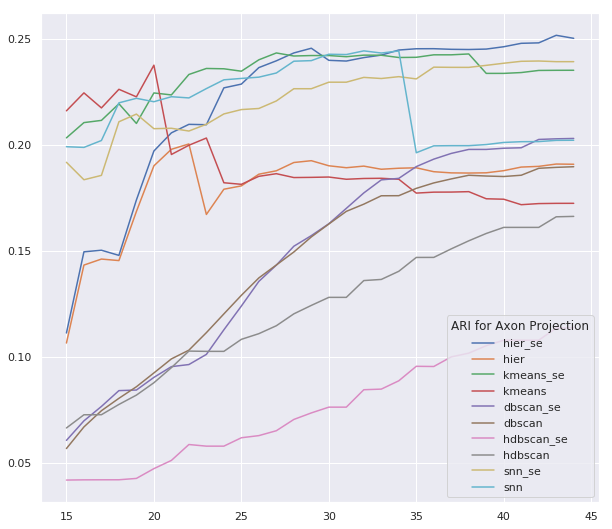

In [41]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,9))
x_ = range(15,45)
plt.plot(x_,hier_AP_list_se, label='hier_se')
plt.plot(x_,hier_AP_list, label='hier')
plt.plot(x_,kmeans_AP_list_se, label='kmeans_se')
plt.plot(x_,kmeans_AP_list, label='kmeans')
plt.plot(x_,dbscan_AP_list_se, label='dbscan_se')
plt.plot(x_,dbscan_AP_list, label='dbscan')
plt.plot(x_,hdbscan_AP_list_se, label='hdbscan_se')
plt.plot(x_,hdbscan_AP_list, label='hdbscan')
plt.plot(x_,snn_AP_list_se, label='snn_se')
plt.plot(x_,snn_AP_list, label='snn')
plt.legend(title='ARI for Axon Projection')
plt.show()

### Only Soma Location

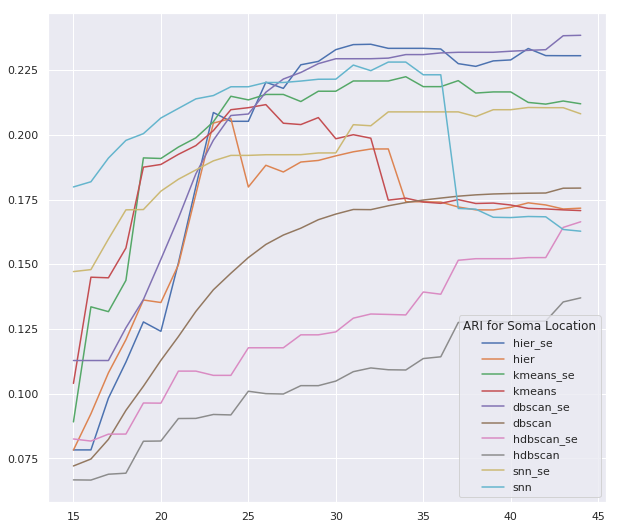

In [39]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,9))
x_ = range(15,45)
plt.plot(x_,hier_SL_list_se, label='hier_se')
plt.plot(x_,hier_SL_list, label='hier')
plt.plot(x_,kmeans_SL_list_se, label='kmeans_se')
plt.plot(x_,kmeans_SL_list, label='kmeans')
plt.plot(x_,dbscan_SL_list_se, label='dbscan_se')
plt.plot(x_,dbscan_SL_list, label='dbscan')
plt.plot(x_,hdbscan_SL_list_se, label='hdbscan_se')
plt.plot(x_,hdbscan_SL_list, label='hdbscan')
plt.plot(x_,snn_SL_list_se, label='snn_se')
plt.plot(x_,snn_SL_list, label='snn')
plt.legend(title='ARI for Soma Location')
plt.show()

## Only Axon Projection with selected Region

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,9))
x_ = range(15,45)
plt.plot(x_,hier_AP_list_se, label='hier_se')
plt.plot(x_,kmeans_AP_list_se, label='kmeans_se')
plt.plot(x_,dbscan_AP_list_se, label='dbscan_se')
plt.plot(x_,dbscan_AP_list, label='dbscan')
plt.plot(x_,hdbscan_AP_list_se, label='hdbscan_se')
plt.plot(x_,hdbscan_AP_list, label='hdbscan')
plt.plot(x_,snn_AP_list_se, label='snn_se')
plt.plot(x_,snn_AP_list, label='snn')
plt.legend(title='ARI for Axon Projection')
plt.show()

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10,9))
x_ = range(15,45)

plt.plot(x_,hier_SL_list_se, label='hier_se')
plt.plot(x_,hier_SL_list, label='hier_SL_list')
plt.plot(x_,kmeans_SL_list_se, label='kmeans_SL_list_se')
plt.plot(x_,kmeans_SL_list, label='kmeans_SL_list')
plt.plot(x_,dbscan_SL_list_se, label='dbscan_SL_list_se')
plt.plot(x_,dbscan_SL_list, label='dbscan_SL_list')
plt.plot(x_,hdbscan_SL_list_se, label='hdbscan_SL_list_se')
plt.plot(x_,hdbscan_SL_list, label='hdbscan_SL_list')
plt.plot(x_,snn_SL_list_se, label='snn_SL_list_se')
plt.plot(x_,snn_SL_list, label='snn_SL_list')
plt.legend(title='Parameter where:')
plt.show()

In [26]:
stooooooooop

NameError: name 'stooooooooop' is not defined

In [ ]:
_ = ns.bestCoCluster(SL_snnDF, nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str = True,return_hex = True), t = 20, selected_list= se_list)


In [ ]:
NeuronAll = []
for iterC in  list(ns.metadata['Cluster'].unique()):
    NeuronAll . append(ns.metadata[ns.metadata['Cluster']==iterC].index.tolist())

In [ ]:
from neuro_morpho_toolbox.plot import cell_in_map
i = 0
j = 0
fig, ax = plt.subplots(5,4, figsize=(7.5, 10))
for iterL in NeuronAll:
    if i % 4 == 0 and i !=0:
        i = 0
        j = j+1
    cell_in_map(ns.neurons, iterL, ns.metadata, ccf_annotation=nmt.annotation, 
                view="Horizontal", color="cluster",alpha=1,ax=ax[j,i])
    i = i+1
    #fig.savefig('../Figure/Cell_in_map.pdf')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,8))

cell_in_map(ns.neurons, iterL, ns.metadata, ccf_annotation=nmt.annotation, 
            view="Horizontal", color="cluster",alpha=1,ax = ax)

In [ ]:
len(list(ns.metadata['Cluster'].unique()))

In [ ]:
import seaborn as sns; sns.set()




colorlist=["#7FC97F","#BEAED4","#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D","#666666","#A6CEE3","#1F78B4","#B2DF8A","#33A02C",
           "#FB9A99","#E31A1C","#FDBF6F","#FF7F00","#CAB2D6","#6A3D9A","#FFFF99","#B15928","#FBB4AE","#B3CDE3",
           "#CCEBC5","#DECBE4","#FED9A6","#FFFFCC","#E5D8BD","#FDDAEC","#F2F2F2","#B3E2CD","#FDCDAC","#CBD5E8",
           "#F4CAE4","#E6F5C9","#FFF2AE","#F1E2CC","#CCCCCC","#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00",
           "#FFFF33","#A65628","#F781BF","#999999","#66C2A5","#FC8D62","#8DA0CB","#E78AC3","#A6D854","#FFD92F",
           "#E5C494","#B3B3B3","#8DD3C7","#FFFFB3","#BEBADA","#FB8072","#80B1D3","#FDB462","#B3DE69","#FCCDE5",
           "#D9D9D9","#BC80BD","#CCEBC5"]
lut = dict(zip(ns.metadata['CellType'].unique(), colorlist))
row_colors = ns.metadata['CellType'].map(lut)
row_colors[row_colors.isnull()]='white'

In [ ]:
DDD=(nmt.get_group_colors(ns.metadata, group_by="CellType", palette="paired", return_str=False, return_colorCode = ))
bestCOCLUSTER(SL_snnDF,DDD,ns)

In [ ]:
bestCOCLUSTER(SL_snnDF,DDD,ns)

In [ ]:
stoppp

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial import distance
hierarchy.linkage(distance.pdist(np.asarray(SL_snnDF)), method = 'single')

In [ ]:
Ztemp= bestCOCLUSTER(DM_hierDF)


In [ ]:
import pickle
def generateNS(featureDF,ns_input,Z_sample,storePath,outname):
    if featureDF.shape!= (0,0):
        pickle_in = open("/home/penglab/FeaCal/ns.pickle","rb")
        example_ = pickle.load(pickle_in)
        ns_input= example_[0]

        index_origin = ns_input.metadata.index.tolist()
        ns_input.UMAP = nmt.UMAP_wrapper(featureDF, n_neighbors=100, min_dist=0.1, n_components=2, 
                                         metric='euclidean',PCA_first=True,n_PC=100)
        index_after = ns_input.UMAP.index.tolist()
        if len(index_after)>len(index_origin ):
            index_update = [i for i in index_after if i in index_origin ]
        else:
            index_update = [i for i in index_origin if i in index_after ]
        
        ns_input.metadata = ns_input.metadata.loc[index_update,:]
    cur_clusters = coclusterResult(Z_sample)
    ns_input.metadata['Cluster'] = ['C' + str(i) for i in cur_clusters] 
    _ = ns_input.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")
    return ns_input

In [ ]:
AP_hierDF  = DM_hierDF

In [ ]:
Ztemp= bestCOCLUSTER(AP_hierDF)
generateNS(pd.DataFrame(),ns,Ztemp,'/home/penglab/FeaCal/','AP_hier_ns')

In [ ]:
_ = ns.FeatureScatter(["CellType", "Hemisphere","Cluster"], map="UMAP")

In [ ]:
DM_kmeans = para_cocluster('Kmeans', par_kmeans2,30, 5000,ns)
DM_kmeansDF = pd.DataFrame(data=DM_kmeans, index=ns.UMAP.index, columns=ns.UMAP.index)
DM_kmeansDF.to_excel('/home/penglab/FeaCal/dataSource/denMor/DM_kmeansDF.xlsx')



In [ ]:
# df = pd.read_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.xlsx", index_col=[0])
# metadata = ns.features['soma_features'].region
# df = df.loc[metadata.index]
# df.to_excel("../Subjective_celltype/tracking_table_QW_hz_LjL_08082019.284_cells.xlsx")

In [ ]:
df = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", index_col=[0])
region_list = pd.read_excel("../Subjective_celltype/tracking_table.284_cells.xlsx", sheet_name=1, header=None)[2].tolist()

metadata = ns.features['soma_features'].region.copy()
metadata['Celltype'] = df.loc[metadata.index, "Confirmed"]
# # metadata['Celltype_note'] = df.loc[metadata.index, "Lijuan Note"]
# # metadata.loc[metadata["Celltype_note"]=="CPU", "Celltype"] = "CPU"
metadata.fillna("Others", inplace=True)
metadata.loc[metadata.Celltype.isin(["TH", "VPM/VPL"]), "Celltype"] = "TH_Uncertain"
metadata.loc[~metadata.Celltype.isin(["Others", "TH_Uncertain"]+region_list), "Celltype"] = "Others"
print(metadata.Celltype.value_counts())
# metadata
pickle.dump([metadata], open("metadata.pickle", "wb"))

## Color setting

In [ ]:
bupu = cl.scales['9']['seq']['BuPu']
greens = cl.scales['9']['seq']['Greens']
set2 = cl.scales['7']['qual']['Set2']
spectral = cl.scales['9']['div']['Spectral']
paired = cl.scales['10']['qual']['Paired']
mpl_colors = []
for i in range(9):
    tp = []
    for j in list(matplotlib.colors.to_rgb("C"+str(i))):
        tp.append(str(int(j*255)))
    tp = ", ".join(tp)
    tp = "rgb(" + tp + ")"
    mpl_colors.append(tp)
   
def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i)/255 for i in tp.split(", ")]
    return res

def get_celltype_colors(metadata):
    u_celltypes = sorted(list(set(metadata.Celltype)))
    color_list = cl.to_rgb(cl.interp(paired, len(u_celltypes)))
    color_list = [rgb_to_list(i) for i in color_list]
    celltype_colors = dict(zip(u_celltypes, color_list))
    if "Others" in u_celltypes:
        celltype_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
    return celltype_colors

celltype_color_dict = get_celltype_colors(metadata)

pickle.dump([celltype_color_dict], open("colors.pickle", "wb"))

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,8))
for i, key in enumerate(list(celltype_color_dict.keys())):
    ax.scatter(0.001, len(celltype_color_dict) - i, c=celltype_color_dict[key], s=100)
    ax.text(0.002, len(celltype_color_dict) - i, key, 
            horizontalalignment='left',
            verticalalignment="center",
            fontdict={"size":16}
           )
    ax.set_xlim(0, 0.01)
    ax.axis("off")

In [ ]:
ns.metadata["CellType"] = metadata.loc[ns.metadata.index, "Celltype"]
clusters = pd.read_csv("clusters.csv", index_col=[0])
ns.metadata['Cluster'] = clusters.loc[ns.metadata.index, "Cluster"]
ns.metadata["CellType_note"] = metadata.loc[ns.metadata.index, "Celltype_note"]

In [ ]:
pickle.dump([ns], open("neuron_set.pickle", "wb"))

In [ ]:
ns.features['projection_features'].normalize(log=True)
pickle.dump([ns.features['projection_features']], open("features_projection.pickle", "wb"))

In [ ]:
ns.features['projection_features'].scaled_data

## Feature 2: soma locations

In [ ]:
pickle.dump([ns.features['soma_features']], open("features_soma.pickle", "wb"))

## Feature 3: axon morphological features

In [ ]:
# 1. Axon overall
df1 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df1.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df1 = df1[use_cols]

feature_name = use_cols
new_feature_name = ['A_'+i.replace(' ', '_') for i in use_cols]
df1.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)


In [ ]:
# 2. Local axon
df2 = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df2.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df2 = df2[use_cols]

feature_name = use_cols
new_feature_name = ['AL_'+i.replace(' ', '_') for i in use_cols]
df2.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

In [ ]:
df = pd.concat([df1, df2], axis=1)
lm_axon = nmt.features("L-measure of axon")
lm_axon.add_raw_data(df)

pickle.dump([lm_axon], open("features_lm_axon.pickle", "wb"))

## Feature 4: dendrite morphological features

In [ ]:
df = pd.read_csv("../Data/swc/mapped/Data_for_analysis/features/axon.features", 
                          header=[0], index_col=[0], delimiter="\t").transpose()
df.rename(columns={'Number of Bifurcatons':'Number of Bifurcations'}, inplace=True)

use_cols = ['Number of Stems', 
            'Overall Width', 'Overall Height', 'Overall Depth', 
            'Total Length', 
            'Max Euclidean Distance', 'Max Path Distance', 
            'Number of Bifurcations', 'Number of Branches', 'Number of Tips',
            'Max Branch Order','Average Contraction', 'Average Fragmentation',
            'Average Bifurcation Angle Local', 'Average Bifurcation Angle Remote', 
            'Hausdorff Dimension'
           ]
df = df[use_cols]

feature_name = use_cols
new_feature_name = ['D_'+i.replace(' ', '_') for i in use_cols]
df.rename(columns=dict(zip(feature_name, new_feature_name)), inplace=True)

lm_dendrite = nmt.features("L-measure of dendrite")
lm_dendrite.add_raw_data(df)

pickle.dump([lm_dendrite], open("features_lm_dendrite.pickle", "wb"))

In [ ]:
print(np.log(10000), np.log(5000))